In [1]:
import pandas as pd
from db import Database
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.colors as mpcolors
import numpy as np
from IPython.display import Latex

db = Database()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})

In [2]:

def get_df(db: Database, mwname, pcap_id, g: bool, pt: str, slot_h=1.0, nn=1, max_slots_h=0):
    where = ''
    if not g and pt == 'qr':
        where = 'true'
    else:
        if g:
            if pt in ['qr', 'q', 'r']:
                where = 'rn_qr=1 and '
            elif pt in ['ok', 'nx']:
                where = 'rn_qr_rcode=1 and '
            pass

        if pt == 'qr':
            where += '(true)'
        elif pt == 'q':
            where += '(is_r is false)'
        elif pt == 'r':
            where += '(is_r is true)'
        elif pt == 'ok':
            where += '(is_r is true) and (rcode = 0)'
        elif pt == 'nx':
            where += '(is_r is true) and (rcode = 3)'
            pass
        pass
    pass

    slot_seconds = 3600 * slot_h

    FROM = f'public.get_message_pcap_all3({pcap_id},0)' if pcap_id else 'public.get_message_healthy_all2()'

    sql = f"""
    SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" 
    FROM {FROM}
    WHERE {where}
    """

    df = pd.read_sql(sql, db.engine).groupby("hour").aggregate({"pn": "sum", "pp": 'sum'})

    df.index = df.index - df.index.min()

    df = df.reindex(pd.Index(range(int(df.index.max()))), fill_value=0)

    df.index.name = 'slot'

    df = df.reset_index()

    if any(df.slot.value_counts() > 1):
        raise Exception('Some values are duplicated.')

    return df

dfs = {}
for idxmw, (mwname, mwid) in enumerate([('caphaw', 54), ('zbot', 46), ('simda', 58), ('unknown', 57)]):
    dfs[mwname] = {}
    for g in [False, True]:
        for idxq, q in enumerate('qr,q,r,ok,nx'.split(',')):
            dfs[mwname][(g, f'{idxq}c.{q}', 1)] = get_df(db, mwname, mwid, g, q, slot_h=1)
            pass
        pass
    pass


In [3]:

import re
import subprocess


index = []
rows = []
for mwidx, mw in enumerate(dfs):
    index.append(mw)
    row = []
    for idxconfig, config in enumerate(dfs[mw]):
        df = dfs[mw][config]
        row += [
            (df['pn'].sum()),
            (df['pp'].sum()),
            df.index.shape[0],
            (df['pn'] > 0).sum(),
            (df['pp'] > 0).sum(),
            f'{round(df[df['pn'] > 0]['pn'].mean(), 2)} + {round(df[df['pn'] > 0]['pn'].std()/df[df['pn'] > 0]['pn'].mean(), 2)}',
            f'{round(df[df['pp'] > 0]['pp'].mean(), 2)} + {round(df[df['pp'] > 0]['pp'].std()/df[df['pp'] > 0]['pp'].mean(), 2)}'
        ]
        pass
    rows.append(row)
    pass

cols_defs = []
for config in list(dfs.values())[0]:
    cols_defs.append((config[0], config[1], '1c.$n$'))
    cols_defs.append((config[0], config[1], '2c.$p$'))
    cols_defs.append((config[0], config[1], '3c.$\\# w$'))
    cols_defs.append((config[0], config[1], '4c.$\\# w|_{\\eta = 0}$'))
    cols_defs.append((config[0], config[1], '5c.$\\# w|_{\\rho > 0}$'))
    cols_defs.append((config[0], config[1], '6c.$\\mu_\\eta \\pm \\sigma_\\eta/\\mu_\\eta$'))
    cols_defs.append((config[0], config[1], '7c.$\\mu_\\rho \\pm \\sigma_\\rho/\\mu_\\rho$'))
    pass


df = pd.DataFrame(rows, index=pd.Index(index, name='mw'), columns=pd.MultiIndex.from_tuples(cols_defs, names=('unique', '$q^*$', 'metric')))

df = df.stack('metric').stack('$q^*$').unstack('mw')
df = df.sort_index(level=[0,1], axis=0)
df = df.swaplevel(0, 1, axis=1).sort_index(level=[0, 1], axis=1)

s = re.sub(r'\dc\.', '', df.to_latex())
s = re.sub(r'False', 'no', s)
s = re.sub(r'True', 'yes', s)
s = re.sub(r'\{r\}', r'{c}', s)
s = re.sub(r'\\multirow\[t\]\{5\}\{\*\}\{(\$.*?\$)\}', r'\\multicolumn{5}{@{}l}{\1} \\\\\n', s)

print(s)
process = subprocess.Popen(
    'pbcopy', env={'LANG': 'en_US.UTF-8'}, stdin=subprocess.PIPE)
process.communicate(s.encode('utf-8'))


\begin{tabular}{llllllllll}
\toprule
 & mw & \multicolumn{2}{c}{caphaw} & \multicolumn{2}{c}{simda} & \multicolumn{2}{c}{unknown} & \multicolumn{2}{c}{zbot} \\
 & unique & no & yes & no & yes & no & yes & no & yes \\
metric & $q^*$ &  &  &  &  &  &  &  &  \\
\midrule
\multicolumn{5}{@{}l}{$n$} \\
 & qr & 40742 & 3174 & 2420 & 18 & 1192 & 46 & 24 & 6 \\
 & q & 21157 & 1602 & 1145 & 9 & 1078 & 23 & 12 & 3 \\
 & r & 19585 & 1572 & 1275 & 9 & 114 & 23 & 12 & 3 \\
 & ok & 13921 & 35 & 57 & 5 & 93 & 22 & 12 & 3 \\
 & nx & 5424 & 1557 & 1212 & 8 & 21 & 4 & 0 & 0 \\
\cline{1-10}
\multicolumn{5}{@{}l}{$p$} \\
 & qr & 23076 & 8154 & 721981 & 5497 & 16020 & 4005 & 13594 & 8589 \\
 & q & 11865 & 4141 & 367054 & 2945 & 8012 & 2003 & 6805 & 4297 \\
 & r & 11211 & 4013 & 354927 & 2552 & 8008 & 2002 & 6789 & 4292 \\
 & ok & 5011 & 53 & 3382 & 1482 & 427 & 311 & 5758 & 3725 \\
 & nx & 6156 & 3980 & 349916 & 2948 & 7281 & 1975 & 1030 & 789 \\
\cline{1-10}
\multicolumn{5}{@{}l}{$\# w$} \\
 & qr & 1005 & 

/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_28605/4284474998.py:39: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack('metric').stack('$q^*$').unstack('mw')
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_28605/4284474998.py:39: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack('metric').stack('$q^*$').unstack('mw')


(None, None)

In [4]:
dfh = get_df(db, 'healthy', None, True, 'nx', slot_h=1)
DFH = dfh[dfh.slot < 8].copy()
dfs = {
    'caphaw': get_df(db, 'caphaw', 54, True, 'nx', slot_h=1),
    'zbot': get_df(db, 'zbot', 46, True, 'nx', slot_h=1),
    'simda': get_df(db, 'simda', 58, True, 'nx', slot_h=1),
    'unknown': get_df(db, 'unknown', 57, True, 'nx', slot_h=1)
}
mws = list(dfs.keys())

In [46]:

negcolor = mpcolors.to_rgba((127/255, 127/255, 255/255, 1))
poscolor_1 = mpcolors.to_rgba((255/255, 127/255, 127/255, 0.8))
poscolor_2 = mpcolors.to_rgba((255/255, 67/255, 67/255, 0.8))
poscolor_3 = mpcolors.to_rgba((255/255, 33/255, 33/255, 0.8))
black = mpcolors.to_rgba((0, 0, 0, 0.5))

def do_plot(df, ax_n, ax_p, num_slots=50):
    df = df.copy()
    print(df.shape[0])

    roll_size = 8
    num_slot_needed = num_slots + roll_size

    df_count = (df['pp'] > 0).rolling(roll_size).sum()
    df_max = df.rolling(roll_size).max()
    df_mean = df.rolling(roll_size).mean()

    if num_slots:
        if df.slot.max() < (num_slots-1):
            raise Exception(f'Not enough slots: {df.slot.max()} < {num_slots}.')
        df = df.iloc[0:num_slots]
        df_max = df_max.iloc[roll_size-1:roll_size - 1 + num_slots]
        df_mean = df_mean.iloc[roll_size-1:roll_size - 1 + num_slots]
        df_count = df_count.iloc[roll_size-1:roll_size - 1 + num_slots]
        pass

    print(df_max.shape[0], roll_size, num_slot_needed)
    print(df_mean.shape[0], roll_size, num_slot_needed)
    print(df_count.shape[0], roll_size, num_slot_needed)

    X = list(range(num_slots))

    ax_n.bar(X, df_count, label='positive windows per group', align='center', color=negcolor,    zorder=3)
    ax_p.bar(X, df_max['pp'],  label='$\\rho^\\uparrow_\\kappa$', align='center', color=poscolor_2,  zorder=3)
    ax_p.bar(X, df_mean['pp'], label='$\\rho^\\mu_\\kappa$',  align='center', color=black,       zorder=3)

    ax_n.set_yticks(list(range(9)))
    ax_p.set_yticks([ int(t) for t in ax_p.get_yticks() ])

    # ax_n.set_ylim(0, 8)
    ax_n.set_xlim(-2, 52)
    ax_p.set_xlim(-2, 52)

    pass


794
50 8 58
50 8 58
50 8 58
1005
50 8 58
50 8 58
50 8 58
219
50 8 58
50 8 58
50 8 58
122
50 8 58
50 8 58
50 8 58


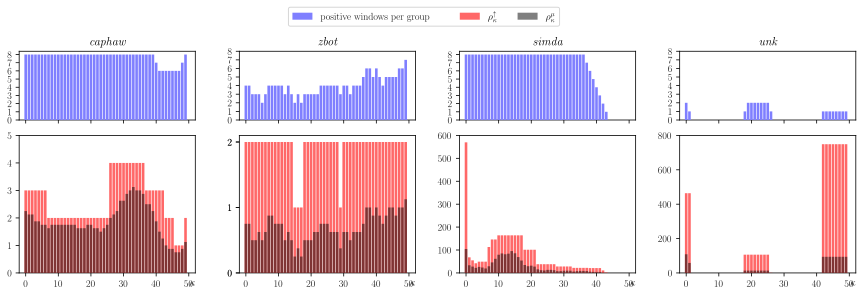

In [45]:

fig2 = plt.figure(figsize=( 15, 4 ))
gs2 = fig2.add_gridspec(2, 4, height_ratios=(0.5, 1), wspace=0.25, hspace=0.15)

# maxslot = max([ dfs[mw].index.max() for mw in mws ])
num_slots = 50

for mwidx, mw in enumerate(mws):

    ax_pn = fig2.add_subplot(gs2[0, mwidx])
    ax_pp = fig2.add_subplot(gs2[1, mwidx])

    try:
        do_plot(dfs[mw], ax_pn, ax_pp, num_slots=num_slots)
    except Exception as e:
        print(mw)
        print(e)
        continue

    ax_pn.set_title(r'\textit{%s}' % mw.replace('nown', ''))
    ax_pn.set_xticklabels([])


    # if mwidx == 3:
    #     ax_pn.legend()
    #     ax_pp.legend()
    #     pass
    ax_pp.set_xlabel('$\\:\\:\\:\\\\:\\:\\:\\\\:\\:\\:\\kappa$', loc='right', labelpad=-10.)
    ax_pp.margins(x=.05)
    # ax_pp.text(0.5, -.2, '$\\alpha=8$', transform=ax_pp.transAxes, ha='center')

    ax_pn.set_xticks(list(range(0,num_slots + 1,10)))
    ax_pp.set_xticks(list(range(0,num_slots + 1,10)))

    pass

h, l = [], []
[ (h.append(a[0]), l.append(a[1])) for ax in fig2.axes for a in list(zip(*ax.get_legend_handles_labels())) if a[1] not in l ]

fig2.legend(h, l, ncols=4, loc='center', bbox_to_anchor=(0.5, 1.0))

fig2.savefig('malicious_s.pdf', bbox_inches='tight')


In [6]:
for idxmw, (mwname, mwid) in enumerate([('caphaw', 54), ('zbot', 46), ('simda', 58), ('unknown', 57)]):
    print(r'%s & $m_%s$' % (mwname, idxmw), end='')
    for g in [False, True]:
        for q in 'qr,q,r,ok,nx'.split(','):
            df = get_df(db, mwname, mwid, g, q, slot_h=1, max_slots_h=50)
            df = df[df.slot <= 50]
            pp = df['pp'].sum() + df['pn'].sum()
            print(f' & {pp:4}', end='')
            pass
    print(' \\\\')

caphaw & $m_0$ & 2209 & 1105 & 1104 & 1104 &  220 &   28 &   14 &   14 &   14 &  111 \\
zbot & $m_1$ &  575 &  288 &  287 &  250 &   38 &  532 &  266 &  266 &  232 &   35 \\
simda & $m_2$ &   47 &   24 &   23 &   22 & 19872 &   18 &    9 &    9 &    8 & 1957 \\
unknown & $m_3$ &   33 &   17 &   16 &   16 & 2866 &    6 &    3 &    3 &    3 & 1729 \\


In [8]:
dfss = {}

for idxmw, (mwname, mwid) in enumerate([('caphaw', 54), ('zbot', 46), ('simda', 58), ('unknown', 57)]):
    print(r'%s & $m_%s$' % (mwname, idxmw), end='')
    for g in [False, True]:
        for q in 'qr,q,r,ok,nx'.split(','):
            _hash = (mwname, mwid, g, q)
            if _hash not in dfs:
                dfss[_hash] = get_df(db, mwname, mwid, g, q, slot_h=1)
            df = dfss[_hash]
            df = df[df.slot <= 50]
            pp = df['pp'].sum() + df['pn'].sum()
            print(f' & {pp:4}', end='')
            pass
    print(' \\\\')

print([ f'${s}$' for s in 'qr,q,r,ok,nx'.split(',') ])

caphaw & $m_0$ & 2209 & 1105 & 1104 & 1104 &  220 &   28 &   14 &   14 &   14 &  111 \\
zbot & $m_1$ &  575 &  288 &  287 &  250 &   38 &  532 &  266 &  266 &  232 &   35 \\
simda & $m_2$ &   47 &   24 &   23 &   22 & 19872 &   18 &    9 &    9 &    8 & 1957 \\
unknown & $m_3$ &   33 &   17 &   16 &   16 & 2866 &    6 &    3 &    3 &    3 & 1729 \\
['$qr$', '$q$', '$r$', '$ok$', '$nx$']


In [9]:
print(' & '.join([ f'${s}$' for s in 'qr,q,r,ok,nx'.split(',') ]))

$qr$ & $q$ & $r$ & $ok$ & $nx$


In [10]:
for idxmw, (mwname, mwid) in enumerate([('caphaw', 54), ('zbot', 46), ('simda', 58), ('unknown', 57)]):
    print(r'%s & $m_%s$' % (mwname, idxmw), end='')
    for g in [False, True]:
        for q in 'qr,q,r,ok,nx'.split(','):
            df = get_df(db, mwname, mwid, g, q, slot_h=1, max_slots_h=50)
            df = df[df.slot <= 50]
            pp = df['pp'].sum() + df['pn'].sum()
            print(f' & {pp:4}', end='')
            pass
    print(' \\\\')

caphaw & $m_0$ & 2209 & 1105 & 1104 & 1104 &  220 &   28 &   14 &   14 &   14 &  111 \\
zbot & $m_1$ &  575 &  288 &  287 &  250 &   38 &  532 &  266 &  266 &  232 &   35 \\
simda & $m_2$ &   47 &   24 &   23 &   22 & 19872 &   18 &    9 &    9 &    8 & 1957 \\
unknown & $m_3$ &   33 &   17 &   16 &   16 & 2866 &    6 &    3 &    3 &    3 & 1729 \\


In [11]:
df

,slot,pn,pp
0,0,3,405
1,1,0,464
2,2,0,0
3,3,0,0
4,4,0,0
5,5,0,0
6,6,0,0
7,7,0,0
8,8,0,0
9,9,0,0


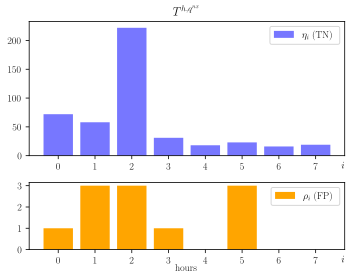

In [12]:


df = DFH.copy()

df['n'] = df['pn'] + df['pp']

fig2 = plt.figure(figsize=( 5, 4 ))
gs2 = fig2.add_gridspec(2, 1, height_ratios=(1, 0.5))

ax_n = fig2.add_subplot(gs2[0])
ax_p = fig2.add_subplot(gs2[1])

ax_n.bar(df.index, df['pn'], label='$\\eta_i$ (TN)', color=mpcolors.to_rgba('#0000FF88'),      zorder=3)
ax_p.bar(df.index, df['pp'], label='$\\rho_i$ (FP)', color='orange',   zorder=3)

ax_n.set_xlabel('$i$', loc='right', labelpad=-10.)
ax_p.set_xlabel('$i$', loc='right', labelpad=-10.)

ax_n.spines[:].set_zorder(4)
ax_p.spines[:].set_zorder(4)

ax_n.legend()
ax_p.legend()

ax_p.set_yticks(list(range(df['pp'].max() + 1)))

_ = ax_p.text(3.5, -1.0, 'hours', ha='center')

ax_n.set_title('$T^{h,q^{nx}}$')
fig2.tight_layout()
fig2.savefig('healthy.pdf')
